## Reconstruction momentum model

In this section we will work with simple model, which consist only momentum final particles. Also, we will reconstruct only momentum for internal particle. Let's start with example, consider decay $K_S \to \pi^+\pi^-$ with **mass** and **kinematic** constraints.

In [1]:
import sys
sys.path.append("../generators/sct-gen")
sys.path.append("../wrapper")

import evtgen

import wrapper as fitter

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
cov = (np.diag([3, 3, 5]) * 1e-3) ** 2

mom_fit = []
mom_init = []
mom_mc = []
chis = []

EVENTS = 10000

for i in range(EVENTS):
    (p3pip, p3pim), p3pip_mc, p3pim_mc = evtgen.generate_decay(cov)
    
    ######### C++ code
    pip = fitter.Particle(211, momentum=p3pip)
    pim = fitter.Particle(-211, momentum=p3pim)
    kaon = fitter.Particle(311, daughters=[pip, pim])
    chi = kaon.fit()
    #########
    
    mom_mc.append(p3pip_mc)
    mom_init.append(p3pip)
    mom_fit.append(pip.momentum())
    chis.append(chi)
    
mom_fit = np.array(mom_fit)
mom_init = np.array(mom_init)
mom_mc = np.array(mom_mc)
chis = np.array(chis)

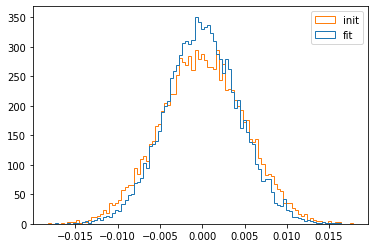

In [4]:
plt.hist([mom_fit[:, 2] - mom_mc[:, 2], 
          mom_init[:, 2] - mom_mc[:, 2]], 
            bins=100, histtype='step', label=['fit', 'init']);
plt.legend()

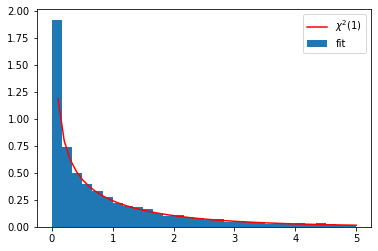

In [5]:
import scipy.stats as stats

x = np.linspace(0, 5)
plt.plot(x, stats.chi2.pdf(x, 1), 'r', label=r'$\chi^2(1)$')
plt.hist(chis, bins=30, range=(0, 5), density=True, label='fit');
plt.legend();

## Full model (without tracks and clusters)

Here we will use model, as if we have a detector of impulses and coordinates directly. 

In [6]:
sys.path.append("../generators/decay-gen")

import jax.random as rjax
from helixgen.phspdecay import generate

/home/ddyak/.local/lib/python3.8/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [7]:
rng = rjax.PRNGKey(seed=1)

In [8]:
weights, genpcls = generate(rng, '', 10000)

In [9]:
r_ks = genpcls['Ks0']['pos']